# 4 Filtering a normalized expression matrix TPM

Made by: Cynthia Soto <br>
Date: March 19th 2021 <br>
Last md: March 23rd 2021 <br>

Filter TPMs atipical values  <br>

**Assumptions:**<br>
1. Matrix expression is in TPMs
2. Filter data ousite a specific range

In [8]:
# Libraries required
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [29]:
#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the temporary files. 

###   Here, I am choosing what dataset I am going to process
general_titles="healthy"
#general_titles=" infected "

try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")        

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion


Notes:
   1. TPM considers the gene length for normalization
   2. TPM is suitable for sequencing protocols where reads sequencing depends on gene length <br>
More details about normalization: https://www.reneshbedre.com/blog/expression_units.html <br>
If you want to better understand why normalize and filter data before any advance analysis, here a post of Jason W Hoskins about **Warnings against using unnormalized, unfiltered read counts for a few reasons** https://www.researchgate.net/post/What-is-a-valid-way-to-measure-variability-of-gene-expression-from-gtex-data <br><br>

Eg. If the TPM for gene A in sample 1 is 3.33 and the TPM in sample B is 3.33, then I know that the exact same proportion of total reads mapped to gene A in both samples. This is because the sum of the TPMs in both samples always add up to the same number.

### Declare functions

In [30]:
#  Plot the distributions: values are raw data - not normalized 

def df_KDE(df_p, samples, main_t, x_label):
    plt.style.use('seaborn-whitegrid')
    kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

    plt.figure(figsize=(10,7), dpi= 80)
    for file in samples:
        sample_data = df_p[file].tolist()
        #print(sample_data[1:10])
        #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
        sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

    plt.title('A.thaliana healthy: Histogram with KDE '+ main_t,fontsize=14);
    plt.xlabel(x_label,fontsize=14);
    plt.ylabel('Probability Density',fontsize=14);
    ## add arbitrary lines to canvas
    #plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
    #plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
    plt.legend(loc='center right',fontsize=12);    
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

In [42]:
## Function to remove genes from a df based on a list of indexes provided of the df
def df_drop_idx_list(df_idx, df_d):  #, df1_d

    ## get a list of gene idx to be remove provided in the df_idx 
    ## drop this idx list from the df provided (df_d)
    ## return the df with the idx provided removed
    
    ## Get the indexes of the gene rows to delete from the df provided
    lst_genes_to_drop=(df_idx.index)
    ## drop the idx marked    
    for i in lst_genes_to_drop: 
        try:
            df_d = df_d.drop([i])
        except:
            pass # doing nothing on exception, not processed because it is already dropped"
    
    return df_d 

### Load your TPM matrix

In [31]:
df_expr=pd.read_csv("all_"+ general_titles +"_TPM.csv", header=0, sep=',')
print(len(df_expr))
df_expr.head(5)

22426


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,AT1G01020,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254
1,AT1G01030,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934
2,AT1G01040,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054
3,AT1G01050,100.854,107.075,106.225,114.017,117.077,51.267,111.675,59.331
4,AT1G01060,0.304,0.100,15.112,715.292,600.107,11.611,21.152,14.058


### evaluation of sample distributions

In [32]:
# chk the distribution
df_plot = df_expr.drop(['Genes'], axis=1)   #, inplace = True
## Get sample list names
sample_lst=df_plot.columns
print(sample_lst)

Index(['healthy30.1', 'healthy30', 'healthy12', 'healthy18.1', 'healthy18',
       'healthy24.1', 'healthy12.1', 'healthy24'],
      dtype='object')


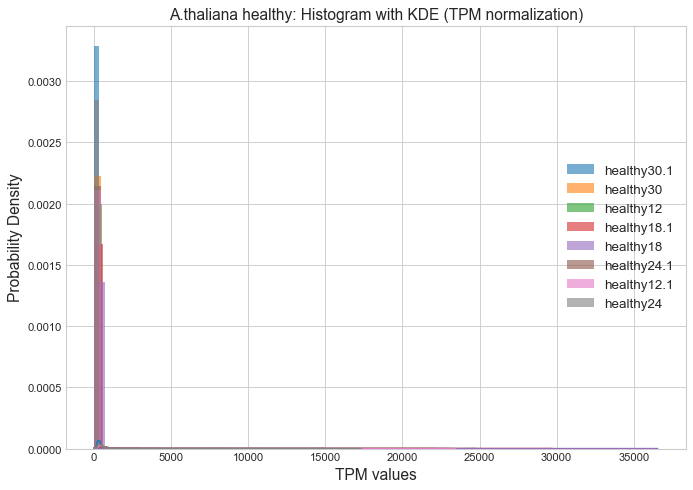

In [33]:
df_KDE(df_plot, sample_lst, '(TPM normalization)', 'TPM values')

### assess the zeros remaining after the normalization by sample 

In [34]:
## Check number of zeros by sample
sr_ceros = df_expr.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

In [35]:
df_ceros

,0
Genes,0
healthy30.1,2460
healthy30,2472
healthy12,2168
healthy18.1,2399
healthy18,1660
healthy24.1,2474
healthy12.1,1811
healthy24,2132


Letś see it is more convinient to use a well tested expression filtering scheme as  "GTEx's scheme" (Genes were selected based on expression **thresholds of >0.1 TPM in at least 20% of samples and ≥6 reads in at least 20% of samples)*** <br>
For my own analysis, deleting genes without counts in 70% of the data set seems convenient, because these genes are underrepresented. And the hight expr.levels underrepresented need also be removed. <br>
***Let's start with the low values.***

In [36]:
# Firts, we check the number of zeros across all samples gotten after the normalization 
s_zeros=(df_expr == 0.000).astype(int).sum(axis=1)

## Added a column to df1 with the counter of zeros
df_expr['zero-counter'] = s_zeros
df_expr.head(20)

,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,AT1G01020,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254,0
1,AT1G01030,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934,0
2,AT1G01040,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054,0
3,AT1G01050,100.854,107.075,106.225,114.017,117.077,51.267,111.675,59.331,0
4,AT1G01060,0.304,0.100,15.112,715.292,600.107,11.611,21.152,14.058,0
5,AT1G01070,1.673,4.096,3.417,10.490,8.898,5.014,3.142,12.197,0
6,AT1G01080,84.450,67.234,122.035,92.050,93.490,54.255,116.441,42.917,0
7,AT1G01090,294.985,315.659,141.144,148.599,151.580,107.100,148.994,104.851,0
8,AT1G01100,184.503,124.054,115.954,90.527,111.356,96.786,122.853,96.813,0
9,AT1G01110,0.301,1.051,0.714,0.535,0.552,1.010,0.345,1.090,0


In [37]:
# Here, we look for genes with zeros in 70% of the samples
# Infected: 17 samples * 0.70 = 11.9; Thus, we are looking for genes with equal or more than 12 zeros.
# Healthy: 8 samples * 0.70 = 5.6; Thus, we are looking for genes with equal or more than 6 zeros.
if general_titles == 'healthy':
    is_zero = (df_expr['zero-counter']>=6)     
else:
    is_zero = (df_expr['zero-counter']>=12)     

df_zero = df_expr[is_zero]
print(len(df_zero))
df_zero.head(7)
## Send the new df to all_log2_counter_cero.csv 
#df_zero.to_csv('', sep='\t', index=False)

1560


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
13,AT1G01150,0.000,0.000,0.000,0.0,0.030,0.000,0.0,0.0,7
28,AT1G01310,3.158,0.105,0.000,0.0,0.000,0.000,0.0,0.0,6
101,AT1G02065,0.167,0.000,0.000,0.0,0.000,0.000,0.0,0.0,7
119,AT1G02250,0.000,0.000,0.601,0.0,0.000,0.000,0.0,0.0,7
145,AT1G02490,0.000,0.000,1.377,0.0,0.000,0.000,0.0,0.0,7
150,AT1G02570,0.000,0.000,0.000,0.0,0.000,0.194,0.0,0.0,7
162,AT1G02705,0.000,0.000,0.000,0.0,0.069,0.000,0.0,0.0,7


In [46]:
# call the custom df_drop_idx_list function to delete the list of indexes to be deleted
print(len(df_expr))
df1 = df_drop_idx_list(df_zero,df_expr)
print(len(df1))
df1.head(5)

22426
20866


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,AT1G01020,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254,0
1,AT1G01030,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934,0
2,AT1G01040,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054,0
3,AT1G01050,100.854,107.075,106.225,114.017,117.077,51.267,111.675,59.331,0
4,AT1G01060,0.304,0.100,15.112,715.292,600.107,11.611,21.152,14.058,0


In [88]:
df1.isin([0]).sum()

Genes               0
healthy30.1      1239
healthy30        1205
healthy12         827
healthy18.1      1012
healthy18         488
healthy24.1      1101
healthy12.1       588
healthy24         806
zero-counter    18132
dtype: int64

Index(['healthy30.1', 'healthy30', 'healthy12', 'healthy18.1', 'healthy18',
       'healthy24.1', 'healthy12.1', 'healthy24'],
      dtype='object')


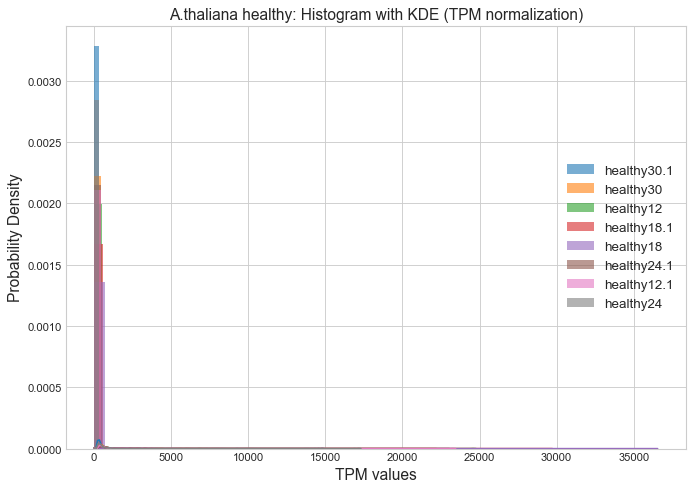

In [89]:
# chk the distribution
df1.drop(['Genes','zero-counter'], axis=1, inplace=True)   #, inplace = True
## Get sample list names
sample_lst=df1.columns
print(sample_lst)
df_KDE(df1, sample_lst, '(TPM normalization)', 'TPM values')

In [90]:
df1.describe()

,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
count,20866.000,20866.000,20866.000,20866.000,20866.000,20866.000,20866.000,20866.000
mean,47.916,47.916,47.922,47.923,47.923,47.922,47.922,47.923
std,297.583,349.220,295.925,366.477,405.278,375.133,284.550,324.228
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.682,1.327,2.712,1.841,1.843,2.041,2.474,2.105
50%,10.174,8.640,11.883,9.305,8.739,9.638,12.054,10.207
75%,30.512,27.521,32.162,26.636,25.347,26.342,33.134,28.582
max,14902.684,22193.965,24767.539,29718.510,36543.769,23032.323,23438.856,17294.532


In [91]:
maxValues = df_plot.max()
print(maxValues)
minValues = df_plot.min()
print(minValues)

healthy30.1    14902.684
healthy30      22193.965
healthy12      24767.539
healthy18.1    29718.510
healthy18      36543.769
healthy24.1    23032.323
healthy12.1    23438.856
healthy24      17294.532
dtype: float64
healthy30.1    0.0
healthy30      0.0
healthy12      0.0
healthy18.1    0.0
healthy18      0.0
healthy24.1    0.0
healthy12.1    0.0
healthy24      0.0
dtype: float64


In [92]:
# find the maximum values of each row
maxValues = df1.max(axis = 1)
print(maxValues)

0         11.852
1          2.418
2         28.536
3        117.077
4        715.292
          ...   
22420      5.778
22421      1.397
22422      4.985
22423     17.128
22425      0.909
Length: 20866, dtype: float64


<AxesSubplot:>

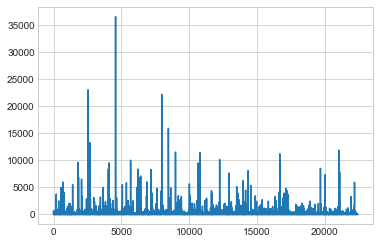

In [93]:
maxValues.plot()

In [ ]:
# Now, let's to check atípical hight expression levels.
# Infected: 17 samples * 0.70 = 11.9; Thus, we are looking for genes with equal or more than 12 zeros.
# Healthy: statistics indicate a mean ~44.59, a SD [391.11 to 274.74 and max ~14902.68 to 36543.76
if general_titles == 'healthy':
    is_zero = (df1['zero-counter']>=6)     
else:
    is_zero = (df1['zero-counter']>=12)     

df_zero = df1[is_zero]
print(len(df_zero))
df_zero.head(7)

In [94]:
df1.iloc[:, 1:9]


,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,7.118,9.930,8.065,7.243,8.547,11.852,9.254
1,1.776,1.944,1.458,1.841,2.418,1.589,0.934
2,25.216,21.880,21.147,17.802,13.734,23.615,15.054
3,107.075,106.225,114.017,117.077,51.267,111.675,59.331
4,0.100,15.112,715.292,600.107,11.611,21.152,14.058
...,...,...,...,...,...,...,...
22420,5.778,1.258,2.516,2.508,0.000,4.455,2.038
22421,1.397,0.368,0.276,0.000,0.000,0.355,0.511
22422,4.009,2.034,2.058,1.824,2.261,3.682,1.906
22423,4.326,11.506,6.110,6.575,9.204,17.128,11.314


In [96]:
len(df1)

20866

In [106]:
cols = df1.select_dtypes('number').columns
cols = cols.tolist()
cols

['healthy30.1',
 'healthy30',
 'healthy12',
 'healthy18.1',
 'healthy18',
 'healthy24.1',
 'healthy12.1',
 'healthy24']

In [118]:
if general_titles == 'healthy':
    is_less = (df1[cols]<=34)     
    df2 = df1[is_less]
else:
    is_less = (df1[cols]<5000)     
#print(is_less)
print(len(df2))
df2.head(7)


20866


,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254
1,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934
2,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.304,0.100,15.112,NaN,NaN,11.611,21.152,14.058
5,1.673,4.096,3.417,10.490,8.898,5.014,3.142,12.197
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# AQUI ME QUEDE

### statistics indicate: a mean ~44.59, a SD ~391.11 to 274.74 and max ~14902.68 to 36543.76
Let's to say that remove genes with no count in 70 % of the dataset & also <br>
Let's to set a threshold to keep values between (0.1 and 5000)

In [161]:
#df_expr.columns
lst_samples = df_expr.columns.to_list()
lst_samples.remove('Genes')
lst_samples.remove('zero-counter')
lst_samples

['healthy30.1',
 'healthy30',
 'healthy12',
 'healthy18.1',
 'healthy18',
 'healthy24.1',
 'healthy12.1',
 'healthy24']

In [163]:
# we assess the values above 0.1
is_newf = (df_expr[lst_samples]>=0.1)    
#is_newf

In [164]:
#is_zero = (df_expr['zero-counter']>=6)     
df_f = df_expr[is_newf]
print(len(df_f))
df_f.head(7)

20866


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,NaN,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254,NaN
1,NaN,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934,NaN
2,NaN,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054,NaN
3,NaN,100.854,107.075,106.225,114.017,117.077,51.267,111.675,59.331,NaN
4,NaN,0.304,NaN,15.112,715.292,600.107,11.611,21.152,14.058,NaN
5,NaN,1.673,4.096,3.417,10.490,8.898,5.014,3.142,12.197,NaN
6,NaN,84.450,67.234,122.035,92.050,93.490,54.255,116.441,42.917,NaN


### now we have information to decide wheater apply a standarization log2(TPM) or filter the atipicals in the TPM df before the standarization 

In [46]:
## Apply Log2 numpy function to convert values to log2(TPM+1)
df_TMP = df_expr.add(.1)

In [47]:
df_TMP.head(5)

,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,8.582,7.218,10.030,8.165,7.343,8.647,11.952,9.354,0.1
1,1.677,1.876,2.044,1.558,1.941,2.518,1.689,1.034,0.1
2,28.636,25.316,21.980,21.247,17.902,13.834,23.715,15.154,0.1
3,100.954,107.175,106.325,114.117,117.177,51.367,111.775,59.431,0.1
4,0.404,0.200,15.212,715.392,600.207,11.711,21.252,14.158,0.1


In [48]:
## Apply Log2 numpy function to convert values to log2(TPM+1)
df_log2TPM = df_TMP.applymap(np.log2)
#df = df.transform(lambda x: np.log2(x))

In [49]:
df_log2TPM

,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,3.101,2.852,3.326,3.029,2.876,3.112,3.579,3.226,-3.322
1,0.746,0.908,1.032,0.639,0.957,1.332,0.756,0.049,-3.322
2,4.840,4.662,4.458,4.409,4.162,3.790,4.568,3.922,-3.322
3,6.658,6.744,6.732,6.834,6.873,5.683,6.804,5.893,-3.322
4,-1.307,-2.324,3.927,9.483,9.229,3.550,4.410,3.824,-3.322
...,...,...,...,...,...,...,...,...,...
22421,0.543,0.582,-1.096,-1.412,-3.322,-3.322,-1.136,-0.712,1.070
22422,2.346,2.039,1.094,1.110,0.944,1.239,1.919,1.004,-3.322
22423,3.833,2.146,3.537,2.635,2.739,3.218,4.107,3.513,-3.322
22424,-3.322,-3.322,-3.322,-3.322,-3.322,-3.322,-1.537,-1.147,2.609


In [ ]:
# chk the distribution
#df_log2TPM.drop(['Genes'], axis=1, inplace = True)
#df_expr.head(3)
## Get sample list names
#sample_lst=df_log2TPM.columns
print(sample_lst)

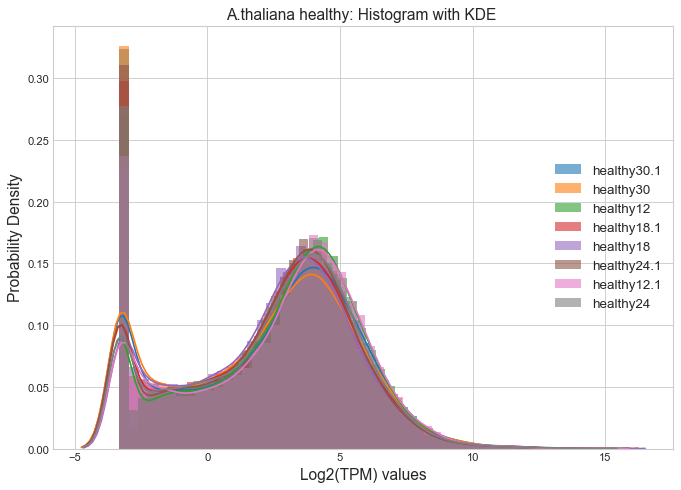

In [51]:
# Plot the distributions: values are raw data - not normalized 
plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    sample_data = df_log2TPM[file].tolist()
    #print(sample_data[1:10])
    #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('A.thaliana healthy: Histogram with KDE ',fontsize=14);
plt.xlabel('Log2(TPM) values',fontsize=14);
plt.ylabel('Probability Density',fontsize=14);
## add arbitrary lines to canvas
#plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
#plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
plt.legend(loc='center right',fontsize=12);    
#plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");

In [71]:
lst_samples = df_expr.columns.to_list()
lst_samples.remove('zero-counter')
lst_samples

['healthy30.1',
 'healthy30',
 'healthy12',
 'healthy18.1',
 'healthy18',
 'healthy24.1',
 'healthy12.1',
 'healthy24']

In [68]:
# Here, we look for genes within 0.1. We are arbitrary set in a treshold to cut off the genes with a low value
is_filter = (df_expr[lst_samples]>=0.1)     
df_f = df_expr[is_filter]
#is_filter2 = (df_expr[lst_samples]<=5000) 
print(df_f.shape)
df_f.head(7)

(22426, 9)


,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254,NaN
1,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934,NaN
2,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054,NaN
3,100.854,107.075,106.225,114.017,117.077,51.267,111.675,59.331,NaN
4,0.304,NaN,15.112,715.292,600.107,11.611,21.152,14.058,NaN
5,1.673,4.096,3.417,10.490,8.898,5.014,3.142,12.197,NaN
6,84.450,67.234,122.035,92.050,93.490,54.255,116.441,42.917,NaN


In [69]:
df_f.drop(['zero-counter'], axis=1, inplace = True)

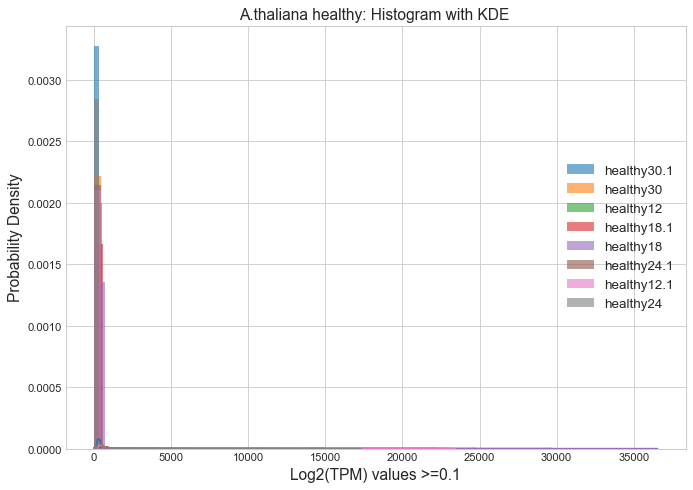

In [70]:
# Plot the distributions: values are raw data - not normalized 
plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    sample_data = df_f[file].tolist()
    #print(sample_data[1:10])
    #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('A.thaliana healthy: Histogram with KDE ',fontsize=14);
plt.xlabel('Log2(TPM) values >=0.1',fontsize=14);
plt.ylabel('Probability Density',fontsize=14);
## add arbitrary lines to canvas
#plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
#plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
plt.legend(loc='center right',fontsize=12);    
#plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");

### Some stats of the new df

In [41]:
df_plot=tpm_df.describe().T
df_plot.head(5)

,count,mean,std,min,25%,50%,75%,max
healthy30.1,22426.0,44.591,287.304,0.0,0.797,8.525,27.881,14902.684
healthy30,22426.0,44.591,337.074,0.0,0.654,7.104,25.009,22193.965
healthy12,22426.0,44.591,285.706,0.0,1.482,10.199,29.627,24767.539
healthy18.1,22426.0,44.591,353.710,0.0,0.942,7.839,24.494,29718.510
healthy18,22426.0,44.591,391.117,0.0,0.997,7.393,23.217,36543.769


In [45]:
## call the fuction df_with_label_ID
df_plot = df_with_label_ID(df_plot)
df_plot.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
2,healthy12,22426.0,44.591,285.706,0.0,1.482,10.199,29.627,24767.539
6,healthy12.1,22426.0,44.591,274.744,0.0,1.248,10.185,30.402,23438.856
4,healthy18,22426.0,44.591,391.117,0.0,0.997,7.393,23.217,36543.769
3,healthy18.1,22426.0,44.591,353.710,0.0,0.942,7.839,24.494,29718.510
7,healthy24,22426.0,44.591,312.984,0.0,1.101,8.638,26.378,17294.532


In [46]:
df_plot.to_csv("../results-data/statistics/all_TPM_healthy_stats.csv", index=False, header=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'healthy12'),
  Text(1, 0, 'healthy12.1'),
  Text(2, 0, 'healthy18'),
  Text(3, 0, 'healthy18.1'),
  Text(4, 0, 'healthy24'),
  Text(5, 0, 'healthy24.1'),
  Text(6, 0, 'healthy30'),
  Text(7, 0, 'healthy30.1')])

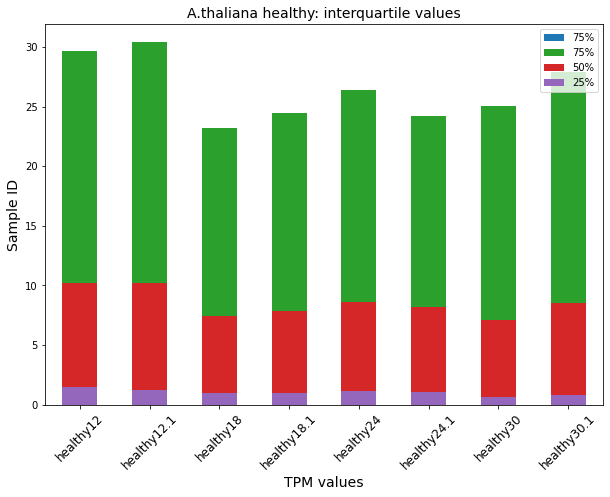

In [49]:
ax = df_plot.plot(x="ID", y="75%", kind="bar", figsize=(10,7))
df_plot.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
df_plot.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
df_plot.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
plt.title('A.thaliana healthy: interquartile values',fontsize=14);
plt.xlabel('TPM values',fontsize=14);
plt.ylabel('Sample ID',fontsize=14);
plt.xticks(rotation=45,fontsize=12)
#plt.show()

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


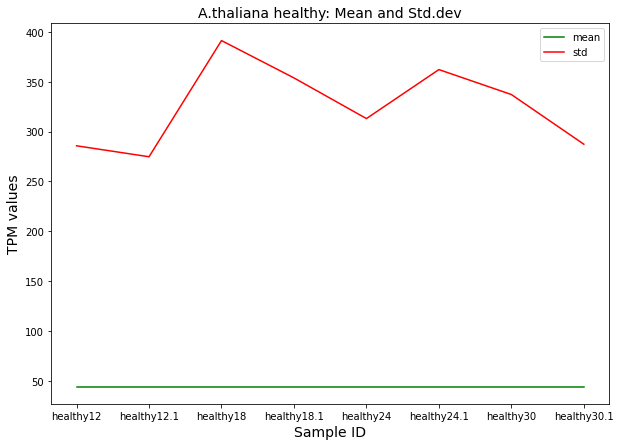

In [50]:
## gca stands for 'get current axis'
ax = plt.gca()
df_plot.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
df_plot.plot(kind='line',x='ID',y='std', color='red', ax=ax)
plt.title('A.thaliana healthy: Mean and Std.dev',fontsize=14);
plt.xlabel('Sample ID',fontsize=14);
plt.ylabel('TPM values',fontsize=14);

In [53]:
## Check number of zeros by sample
sr_ceros = tpm_df.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

In [54]:
df_ceros

,0
healthy30.1,2460
healthy30,2472
healthy12,2168
healthy18.1,2399
healthy18,1660
healthy24.1,2474
healthy12.1,1811
healthy24,2132


### Now explore the new distributions with no zeros across all samples
Plot all the sample in one plot (histogram and KDE)

In [74]:
# load file to be plotted
print(os.getcwd())
df_nozeros = pd.read_csv("matrices_de_expresion/all_healthy_TPM.csv", sep=',')  
df_nozeros.drop(['Genes'], axis=1, inplace = True)
df_nozeros.head(3)

/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data


,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254
1,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934
2,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054


In [75]:
## Get sample list names
sample_lst=df_nozeros.columns
print(sample_lst)
df_nozeros.head(5)

Index(['healthy30.1', 'healthy30', 'healthy12', 'healthy18.1', 'healthy18',
       'healthy24.1', 'healthy12.1', 'healthy24'],
      dtype='object')


,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,8.482,7.118,9.930,8.065,7.243,8.547,11.852,9.254
1,1.577,1.776,1.944,1.458,1.841,2.418,1.589,0.934
2,28.536,25.216,21.880,21.147,17.802,13.734,23.615,15.054
3,100.854,107.075,106.225,114.017,117.077,51.267,111.675,59.331
4,0.304,0.100,15.112,715.292,600.107,11.611,21.152,14.058


[1.576823961409228, 28.5360820774917, 100.8535504754142, 0.3042448448015493, 1.6725085063401974, 84.45013365346955, 294.98488185011206, 184.5032082404041, 0.3011062777371877]
[1.7759387559573026, 25.215784219514394, 107.07480578617502, 0.09968396300539492, 4.0958529344969214, 67.23381232098718, 315.6586099666594, 124.0537950343144, 1.0512990646302562]
[1.9444074765414232, 21.880177400684282, 106.22473141969598, 15.111714694154658, 3.416990201782235, 122.03536434936554, 141.14366503805002, 115.95360192933157, 0.7140367062994791]
[1.4576723717792774, 21.146622884578928, 114.01708520274781, 715.2919222722079, 10.49048410403576, 92.0497755461456, 148.5990606538409, 90.52691867893611, 0.5352949892274556]
[1.840952126384375, 17.801530884862355, 117.07696536559791, 600.1074576403132, 8.897855582627235, 93.49020656690699, 151.57990388379292, 111.35569408188067, 0.5524255278945212]
[2.4180567821951064, 13.734209136709714, 51.26669630993972, 11.610955350547322, 5.014491048607068, 54.255149050502

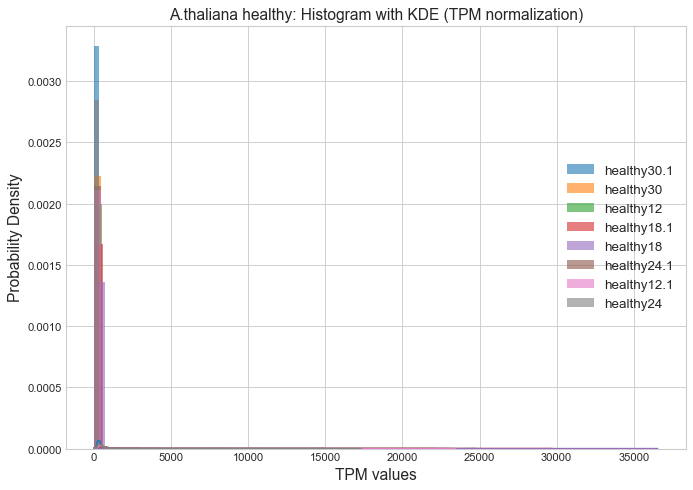

In [78]:
# Plot the distributions: values are raw data - not normalized 

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    sample_data = df_nozeros[file].tolist()
    print(sample_data[1:10])
    #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('A.thaliana healthy: Histogram with KDE (TPM normalization)',fontsize=14);
plt.xlabel('TPM values',fontsize=14);
plt.ylabel('Probability Density',fontsize=14);
## add arbitrary lines to canvas
#plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
#plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
plt.legend(loc='center right',fontsize=12);    
#plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");